In [1]:
"""
import packages
"""
import os, glob
import pandas as pd
import numpy as np
import math, random
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.signal import find_peaks

In [2]:
"""
import custom modules
"""
from module_.readText import read_hh
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from module_.info.hh101_info import baseline_activities

# hh101 (CASAS, 1-resident, serialized)

In [3]:
"""
0. load casas dataset: hh101
"""
# with open('dataset/hh/hh101/ann.txt','rb') as f: 
#     rawdata=f.readlines()
# events=read_hh(rawdata)
# events=np.array(events)
events=np.load("./preprocessed/test/ann.npy")

In [4]:
"""
1. remove all except M and D
"""
# events_md=np.array([event for event in events if event[0][0] in ['M', 'D']])
events_md=np.array([event for event in events if event[3]!="" and event[0][0] in ['M', 'D']])
print(events_md.shape)

for i in range(events_md.shape[0]):
    events_md[i,3]=baseline_activities[events_md[i,3]]
print(set(events_md[:,3]))

trs_md=[i for i in range(len(events_md)) if events_md[i][3]!=events_md[max(i-1,0)][3]]
print(len(trs_md))

# for i in range(events_md.shape[0]):
#     events_md[i,3]='Idle' if events_md[i,3]=="" else events_md[i,3]

episodes, trs, tags = [], [], []
previdx=0
for i in range(len(trs_md)-1):
    # left activity
    # right activity
    left=np.array(events_md[previdx:trs_md[i]])
    right=np.array(events_md[trs_md[i]:trs_md[i+1]])
    episode=np.concatenate((left, right))
    # print(episode.shape)
    episodes.append(episode)
    trs.append(left.shape[0])
    tags.append("{}-{}".format(left[0][3], right[0][3]))

    previdx=trs_md[i]

(149769, 4)
{'Sleep', 'Bathe', 'Eat', 'Personal_Hygiene', 'Relax', 'Leave_Home', 'Bed_Toilet_Transition', 'Other', 'Wash_Dishes', 'Work', 'Cook', 'Enter_Home'}
1960


107 107


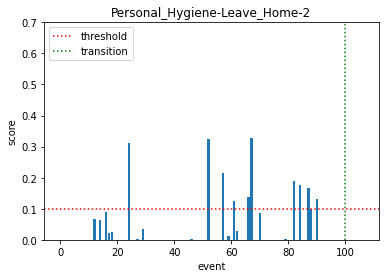

In [7]:
"""make combinations
    1. pick one group type
    2. pick an activity stream from the group
    3. pick another group type w/o type 1.
    4. pick an activity stream from the group
"""

data_name='hh101'
metric='SEP'

for i, eps in enumerate(episodes):
    if i<2:
        continue
    # if i%10==0:
    #     print("{}/{}".format(i, len(episodes)))
    sensor_list=sorted(set(eps[:,0]))
    features=feature_extraction(eps, data_name, sensor_list)
    scores=change_point_detection(features, i, tags[i], data_name=data_name, metric=metric, save=True)
    print(len(eps), len(scores))
    # scores=np.array(scores)
    # scores[scores<0]=0

    # print(max(scores), min(scores))
    # scores=[scores[max(0, si-1)]+scores[max(0, si-2)] for si in range(len(scores))]
    # peak, _ =find_peaks(scores)
    # alarms=[p for p in range(len(scores)) if scores[p]>0.1]
    
    # peaks=[]
    # latest_timestamp=None
    # alarming=False
    # for pp, pidx in enumerate(alarms):
    #     if pp==0:
    #         latest_timestamp=float(eps[pidx][2])
    #         peaks.append(pidx)
    #     else:
    #         counterpart_timestamp=float(eps[pidx][2])
    #         if abs(latest_timestamp-counterpart_timestamp)>20:
    #             peaks.append(pidx)
    #             latest_timestamp=counterpart_timestamp
            
    # negative=[n for n in range(len(scores)) if n not in peaks]
###
    plt.title("{}-{}".format(tags[i], i))
    plt.ylabel('score')
    plt.xlabel('event')
    plt.ylim(0,0.7)
    plt.bar(range(len(scores)), scores)
    # plt.bar(peaks, scores[peaks], color='g')
    # plt.bar(negative, scores[negative], color='b')
    plt.axhline(y=0.1, linestyle=':', color='r', label='threshold')
    plt.axvline(x=trs[i], linestyle=':', color='g', label='transition')
    plt.legend()
    plt.savefig("./outputs/{}/{}/{}/{}/graph.png".format(data_name, metric, tags[i], i))
    # plt.clf()
    break
###

In [6]:
"""
    hh101 Evaluation
    - load scores
"""

data_name='hh101'
metric='SEP'

total_counts=np.zeros(4)
denom = numer = 0
for activity_folder in glob.glob("./outputs/{}/{}/*".format(data_name, metric)):
    # one type of pairs
    activity_pair=activity_folder.split("/")[-1]
    print(activity_pair)
    pair_counts=np.zeros(4) # TP, FP, TN, FN

    for episode_folder in glob.glob("{}/*".format(activity_folder)):
        eps_order=int(episode_folder.split("/")[-1])
        if eps_order>=100:
            continue
        denom+=1
        eps, point=episodes[eps_order], trs[eps_order]
        scores=np.load("{}/scores.npy".format(episode_folder))

        # peaks, _ = find_peaks(scores)
        positives=[i for i in range(len(scores)) if scores[i]>0.1]
        numer+=len(positives)
        # positives=[i for i in range(len(scores)) if scores[i]>0.3]
        ttimestamp=float(eps[point][2])

        for i in range(len(scores)):
            if i in positives:
                if i==point:
                    pair_counts[0]+=1
                else:
                    timestamp_b=float(eps[i-1][2])
                    timestamp_a=float(eps[i][2])
                    if abs(ttimestamp-timestamp_b)<10 or abs(ttimestamp-timestamp_a)<10:
                        pair_counts[0]+=1
                    else:
                        pair_counts[1]+=1
            else:
                if i==point:
                    pair_counts[3]+=1
                else:
                    pair_counts[2]+=1
    if pair_counts[0]+pair_counts[3]==0 or pair_counts[1]+pair_counts[2]==0:
        continue
    TPR_=pair_counts[0]/(pair_counts[0]+pair_counts[3])
    FPR_=pair_counts[1]/(pair_counts[1]+pair_counts[2])
    print("Avg. TPR and FPR: ({}, {})".format(TPR_, FPR_))

    total_counts+=pair_counts

TPR=total_counts[0]/(total_counts[0]+total_counts[3])
FPR=total_counts[1]/(total_counts[1]+total_counts[2])
print("Total Avg. TPR and FPR: ({}, {})".format(TPR, FPR))

print(numer/denom)

Other-Relax
Avg. TPR and FPR: (1.0, 0.2926829268292683)
Relax-Personal_Hygiene
Avg. TPR and FPR: (0.0, 0.136)
Personal_Hygiene-Leave_Home
Avg. TPR and FPR: (0.0, 0.10377358490566038)
Total Avg. TPR and FPR: (0.3333333333333333, 0.14705882352941177)
13.666666666666666
